# Human gene-disease network (2005)

The network is an undirected bipartite graph of associations between human genes and human diseases.

Link to the paper: http://www.pnas.org/content/pnas/104/21/8685.full.pdf

Dataset link (gephi format): http://gephi.org/datasets/diseasome.gexf.zip

# List of contents
- <a href="#intro">Intro</a>
    - <a href="#plot">Plot functions</a>
- <a href="#eda">Graph EDA</a>
    - <a href="#eda_bi">Bipartite Graph</a>
        - <a href="#eda_bi_basic">Basic graph overview</a>
        - <a href="#eda_bi_cycle">Cycles</a>
        - <a href="#eda_bi_cluster">Clustering</a>
        - <a href="#eda_bi_deg">Degree distribution</a>

# <a id="intro">Intro</a>
Let's import some awesome libraries and load that son of a gun in.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

We load the edgelist and node attributes into pandas dataframes first.

In [2]:
df = pd.read_csv("../data/disease_edgelist.csv")
df_att = pd.read_csv("../data/disease_attributes.csv",index_col="Id")
df = df.iloc[:1550]
display(df.head(3),df_att.head(3))

,Source,Target,Edge_id
0,1285,3211,0
1,468,2914,1
2,416,3825,2


,Label,Class,Subclass
Id,,,
55,Deafness,disease,"Ear,Nose,Throat"
47,Leukemia,disease,Cancer
114,Colon cancer,disease,Cancer


Here's a little bit of an overview of the attributes.

In [3]:
df_att.describe()

,Label,Class,Subclass
count,1419,1419,1419
unique,1418,2,23
top,Neurofibromatosis,gene,gene
freq,2,903,903


There appears to be two of the same labels. These nodes are:

In [4]:
df_att[df_att.duplicated(keep=False)]

,Label,Class,Subclass
Id,,,
795,Neurofibromatosis,disease,Cancer
833,Neurofibromatosis,disease,Cancer


Now, we load the graph in straight from the dataframe, and set all the node attributes.

In [5]:
G = nx.convert_matrix.from_pandas_edgelist(df,"Source","Target",create_using=nx.Graph())
nx.set_node_attributes(G,df_att.to_dict(orient="index"))

## <a id="plot">Plot functions</a>

In [6]:
def figsize(scale,t=None):
    fig_width_pt = 426.79135
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = fig_width*golden_mean
    if t == 1:
        return [fig_height,fig_height]
    elif t == 2:
        golden_mean = (np.sqrt(5.0)-1.0)/3.0
        fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

def apply_settings():
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rc("font",family="serif")
    plt.rc("legend",frameon=True)
    plt.rc("savefig",dpi=500)

def newfig(width,t=None):
    apply_settings();
    plt.clf();
    fig = plt.figure(figsize=figsize(width,t));
    ax = fig.add_subplot(111);
    return fig, ax

def savefig(fig,filename):
    fig.savefig("{}.pgf".format(filename),bbox_inches="tight")
    fig.savefig("{}.pdf".format(filename),bbox_inches="tight")
    fig.savefig("{}.png".format(filename),bbox_inches="tight")

#args = {'cmap':'Pastel1','rot':0}
args = {"cmap":"Set3","rot":0}

# <a id="eda">Graph EDA</a>
Since we're dealing with a bipartite network, there are three different graphs we can look at:
* The bipartite graph
* The human disease network (HDN)
* The disease gene network (GDN)

We'll go over all of them.


## <a id="eda_bi">Bipartite Graph</a>
### <a id="eda_bi_basic">Basic graph overview</a>
Number of nodes and edges.

In [7]:
V = G.number_of_nodes()
E = G.number_of_edges()
V,E

(1419, 1550)

Is the graph truly bipartite?

**Definition:** A bipartite graph is a graph whose vertices can be divided into two disjoint and independent sets, such that every edge connects a vertex in one set to the other.

In [8]:
nx.is_bipartite(G)

True

How dense is the graph?

**Definition:** In an undirected simple graph, the graph density is defined as
\begin{equation*}
    D = \frac{2 |E|}{|V|(|V|-1)},
\end{equation*}

which can be interpreted as how close to the maximal number of edges the graph has. The opposite of a dense graph is a *sparse* graph.

In [9]:
D_G = nx.density(G)
D_G

0.0015406467336798297

### <a id="eda_bi_cycle">Cycles</a>
**Definition:** A cycle is a path of edges and vertices wherein a vertex is reachable from itself.

**Corollary:** A bipartite graph is a graph that does not contain any odd-length cycles.

Are there any cycles? If so, what is a cycle basis for the graph?

**Definition:** A cycle basis of a graph is a minimal collection of cycles such that any cycle in the network can be written as a combination of cycles in the basis.

**Example from Wikipedia:** In bioinformatics, cycle bases have been used to determine haplotype information from genome sequence data. Cycle bases have also been used to analyze the tertiary structure of RNA.

In [10]:
Cb_G = nx.cycle_basis(G)
len(Cb_G)

132

In [11]:
e = sum([1 if len(cycle) % 2 == 0 else 0 for cycle in Cb_G])
print("{} cycles have an even length.".format(e))
print("{} cycles have an odd length.".format(len(Cb_G)-e))

132 cycles have an even length.
0 cycles have an odd length.


### <a id="eda_bi_cluster">Clustering</a>
Clustering is a measure of the degree to which nodes in a graph tend to cluster together. Usually divided into *global* and *local* clustering referring to the measure in the graph overall and in a single node respectively.

**Definition:** The global clustering coefficient or *transitivity* is the ratio between triangles present in the graph and the number of possible triangles. It can be defined in many ways, yet the most rigourous is the fraction of paths of length two in a graph $G$ that are closed over all paths of length two in $G$. This can more commonly be stated as
\begin{equation*}
    C_{G} = \frac{3 \times \text{number of triangles in the graph}}
    {\text{number of connected triplets of vertices}}.
\end{equation*}

For a bipartite graph this measure is always 0 as no odd-length cycles are possible, hence no triangles exist in the graph.

In [12]:
C_G = nx.transitivity(G)
C_G

0

Average local clustering as defined by https://en.wikipedia.org/wiki/Clustering_coefficient#Global_clustering_coefficient.

In [13]:
C_avg_G = nx.average_clustering(G)
C_avg_G

0.0

Clustering for bipartite graphs as defined by https://toreopsahl.com/tnet/two-mode-networks/clustering/ 

### <a id="eda_bi_deg">Degree distribution</a>
For this we'll need the Counter module, and we'll make a function to produce all our precious degree metrics. We'll also make a function that can return our dataframe in bins for our log-binning plot.

In [14]:
from collections import Counter

def deg_df(g):
    deg = dict(nx.degree(g))
    deg_df = pd.DataFrame(list(Counter(deg.values()).items()),columns=["k","count"]).sort_values(by="k")
    deg_df["p(k)"] = deg_df["count"] / deg_df["count"].sum()
    deg_df["log_k"] = np.log10(deg_df["k"])
    deg_df["log_p(k)"] = np.log10(deg_df["p(k)"])
    deg_df.sort_values(by="k",ascending=False,inplace=True)
    deg_df["cum_p(k)"] = deg_df["p(k)"].cumsum()
    deg_df["log_cum_p(k)"] = np.log10(deg_df["cum_p(k)"])
    display(deg_df.head(3))
    return deg_df

def log_bin(df,b=2): #not fully functional yet
    df = df.sort_values(by="k").reset_index(drop=True)
    n_bins = int(np.log(df.shape[0])/np.log(b))
    bin_df = pd.DataFrame(index=[i for i in range(n_bins+1)],columns=df.columns)
    for i in range(n_bins):
        bin_df.iloc[i] = df.iloc[int(b**i-1):int(b**(i+1)-1)].sum()
    bin_df.iloc[i+1] = df.iloc[int(b**(i+1)-1):].sum()
    bin_df = bin_df.astype("float64")
    return bin_df

In [15]:
G_deg = deg_df(G)

,k,count,p(k),log_k,log_p(k),cum_p(k),log_cum_p(k)
19,41,1,0.000705,1.612784,-3.151982,0.000705,-3.151982
22,37,1,0.000705,1.568202,-3.151982,0.001409,-2.850952
18,34,1,0.000705,1.531479,-3.151982,0.002114,-2.674861


Now let's see the degree histogram.

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

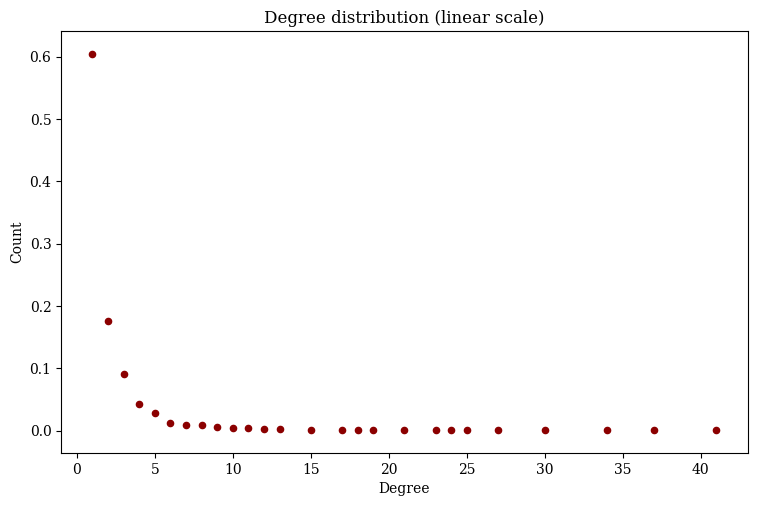

In [16]:
fig,ax = newfig(1.5)
G_deg.plot.scatter(x="k",y="p(k)",ax=ax,title="Degree distribution (linear scale)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

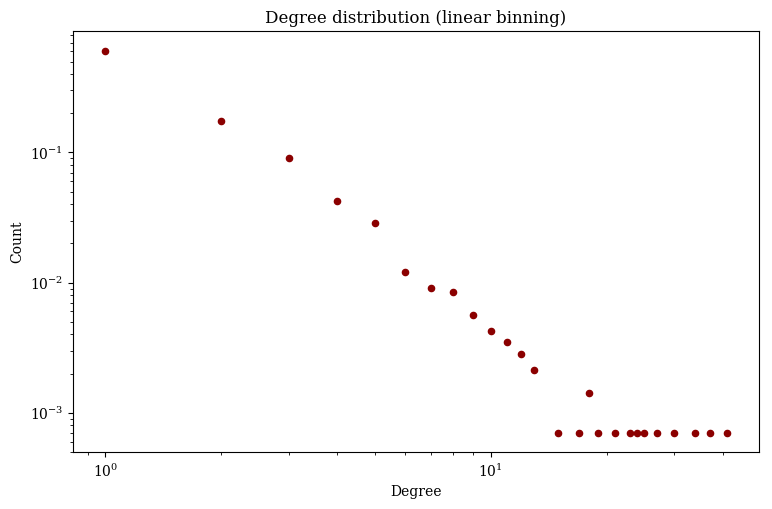

In [17]:
fig,ax = newfig(1.5)
G_deg.plot.scatter(x="k",y="p(k)",loglog=True,ax=ax,title="Degree distribution (linear binning)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

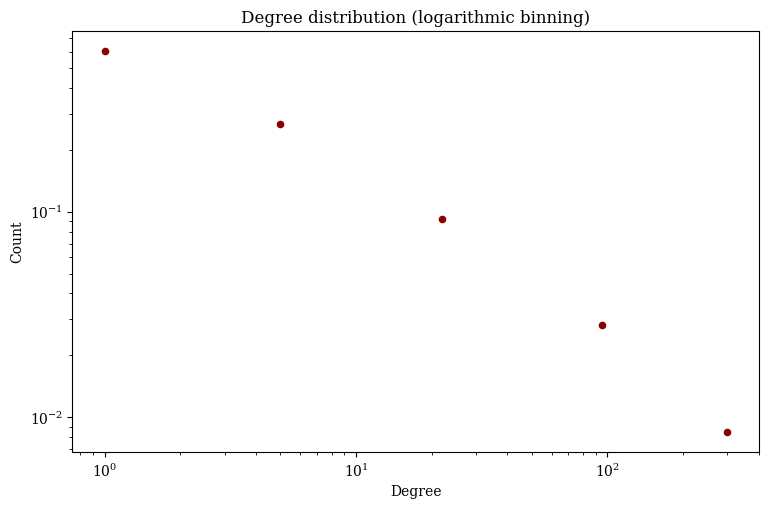

In [18]:
log_df = log_bin(G_deg,b=2)

fig,ax = newfig(1.5)
log_df.plot.scatter(x="k",y="p(k)",loglog=True,ax=ax,title="Degree distribution (logarithmic binning)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

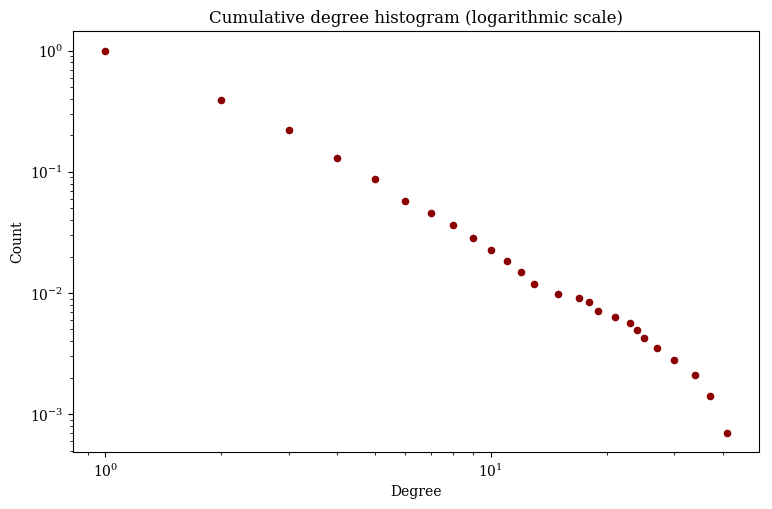

In [19]:
fig,ax = newfig(1.5)
G_deg.plot.scatter(x="k",y="cum_p(k)",loglog=True,ax=ax,title="Cumulative degree histogram (logarithmic scale)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

## Create HDN and DGN
To be made.

HDN

In [20]:
disease_neigh = dict()
for gene in df["Target"]:
    neigh = [n for n in G[gene]]
    for i in range(len(neigh)):
        for j in range(i+1,len(neigh)):
            disease_neigh[(neigh[i],neigh[j])] = disease_neigh.get((neigh[i],neigh[j]),0) + 1

GDN

In [21]:
gene_neigh = dict()
for disease in df["Source"]:
    neigh = [n for n in G[disease]]
    for i in range(len(neigh)-1):
        for j in range(i+1,len(neigh)):
            gene_neigh[(neigh[i],neigh[j])] = gene_neigh.get((neigh[i],neigh[j]),0) + 1
        

## HDN & GDN overview
* With the simple projection 


In [22]:
from projection_test.projection import simple_weighting

In [23]:
hdn, gdn = simple_weighting(G)

### Verticies and Edges

In [24]:
def V_and_E(G):
    V = G.number_of_nodes()
    E = G.number_of_edges()
    print("Verticies: ",V,"Edges: ",E)
print("HDN")
V_and_E(hdn)
print("\n\n","GDN")
V_and_E(gdn)

HDN
Verticies:  516 Edges:  1188


 GDN
Verticies:  903 Edges:  6760


### Density

In [25]:
D_hdn = nx.density(hdn)
print("HDN: ",D_hdn)

D_gdn = nx.density(gdn)
print("GDN: ",D_gdn)

HDN:  0.008941070219011063
GDN:  0.016599018300663224


## Cycles

### HDN

In [26]:
Cb_hdn = nx.cycle_basis(hdn)
len(Cb_hdn)

673

In [27]:
e = sum([1 if len(cycle) % 2 == 0 else 0 for cycle in Cb_hdn])
print("{} cycles have an even length.".format(e))
print("{} cycles have an odd length.".format(len(Cb_hdn)-e))

16 cycles have an even length.
657 cycles have an odd length.


### GDN

In [28]:
Cb_gdn = nx.cycle_basis(gdn)
len(Cb_gdn)

5858

In [29]:
e = sum([1 if len(cycle) % 2 == 0 else 0 for cycle in Cb_gdn])
print("{} cycles have an even length.".format(e))
print("{} cycles have an odd length.".format(len(Cb_gdn)-e))

21 cycles have an even length.
5837 cycles have an odd length.


## Clustering

### HDN

In [30]:
C_hdn = nx.transitivity(hdn)
C_hdn

0.4304705634100021

In [31]:
C_avg_hdn = nx.average_clustering(hdn)
C_avg_hdn

0.6358304997771197

### GDN

In [32]:
C_gdn = nx.transitivity(gdn)
C_gdn

0.8485712754619017

In [33]:
C_avg_gdn = nx.average_clustering(gdn)
C_avg_gdn

0.8530352830385517

## Degrees

In [34]:
hdn_deg = deg_df(hdn)
gdn_deg = deg_df(gdn)

,k,count,p(k),log_k,log_p(k),cum_p(k),log_cum_p(k)
16,50,1,0.001938,1.698970,-2.71265,0.001938,-2.712650
17,30,1,0.001938,1.477121,-2.71265,0.003876,-2.411620
22,27,1,0.001938,1.431364,-2.71265,0.005814,-2.235528


,k,count,p(k),log_k,log_p(k),cum_p(k),log_cum_p(k)
47,70,2,0.002215,1.845098,-2.654658,0.002215,-2.654658
46,65,1,0.001107,1.812913,-2.955688,0.003322,-2.478566
5,64,1,0.001107,1.806180,-2.955688,0.004430,-2.353628


### HDN

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

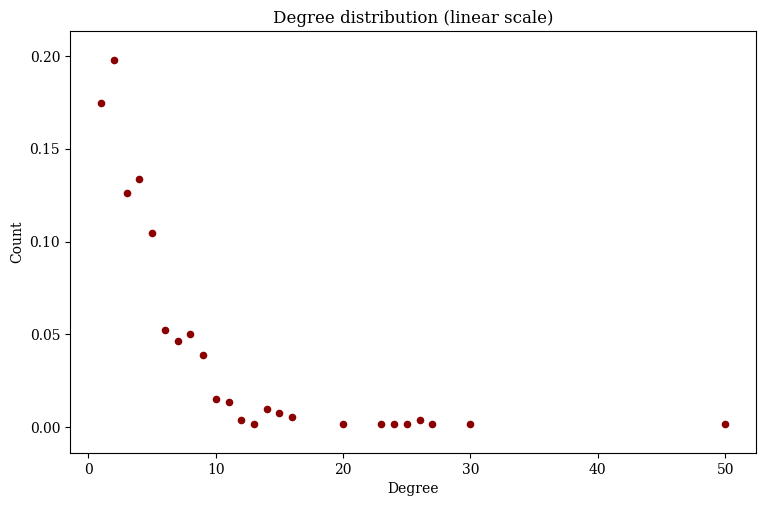

In [35]:
fig,ax = newfig(1.5)
hdn_deg.plot.scatter(x="k",y="p(k)",ax=ax,title="Degree distribution (linear scale)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

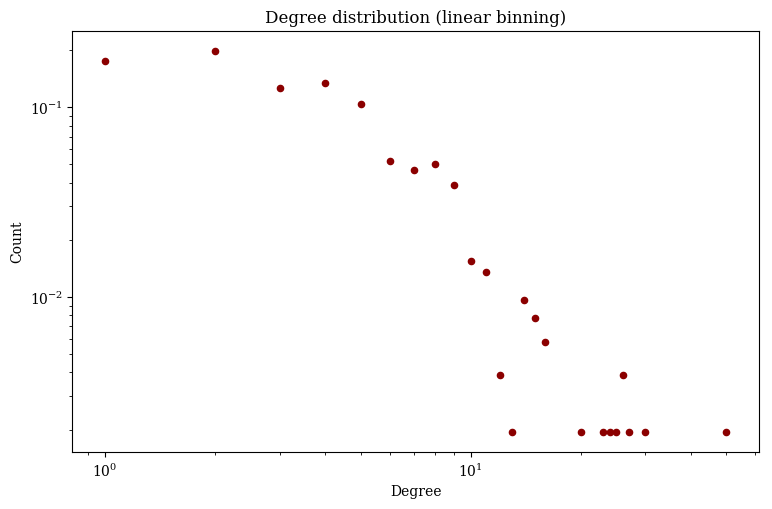

In [36]:
fig,ax = newfig(1.5)
hdn_deg.plot.scatter(x="k",y="p(k)",loglog=True,ax=ax,title="Degree distribution (linear binning)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

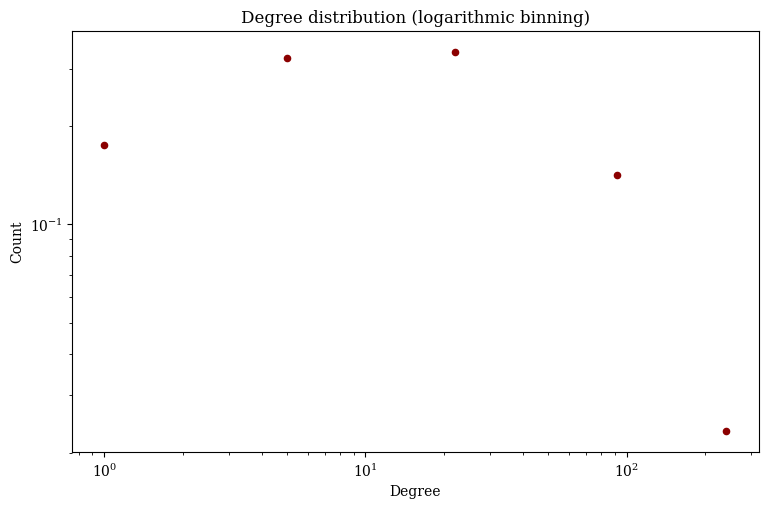

In [37]:
log_df = log_bin(hdn_deg,b=2)

fig,ax = newfig(1.5)
log_df.plot.scatter(x="k",y="p(k)",loglog=True,ax=ax,title="Degree distribution (logarithmic binning)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

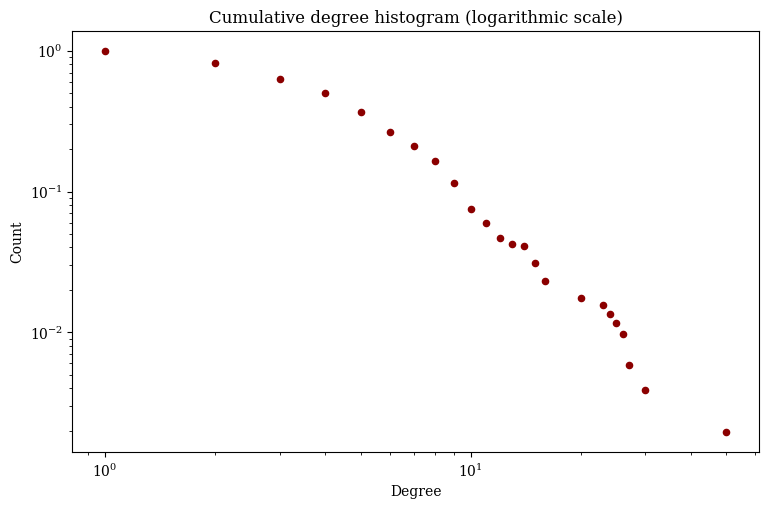

In [38]:
fig, ax = newfig(1.5)
hdn_deg.plot.scatter(x="k", y="cum_p(k)", loglog=True, ax=ax,
                     title="Cumulative degree histogram (logarithmic scale)", c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

### GDN

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

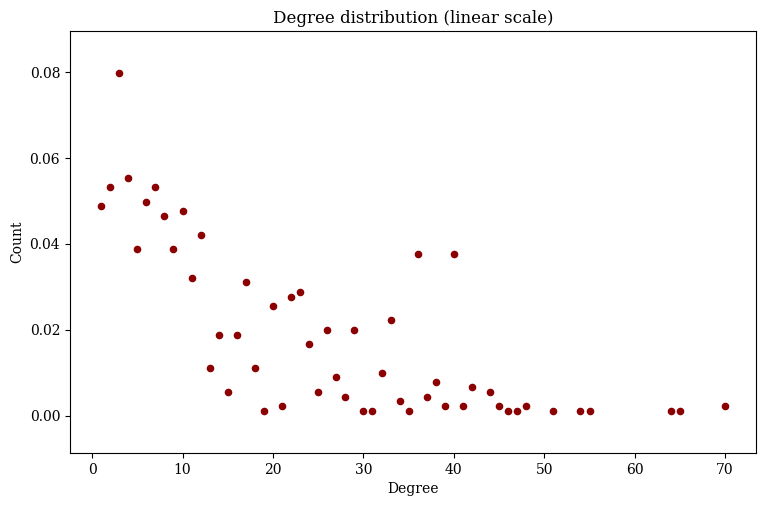

In [39]:
fig,ax = newfig(1.5)
gdn_deg.plot.scatter(x="k",y="p(k)",ax=ax,title="Degree distribution (linear scale)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

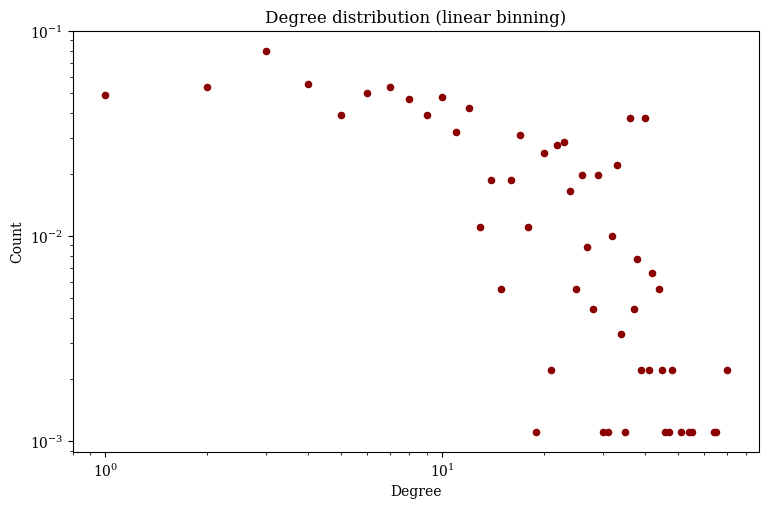

In [40]:
fig,ax = newfig(1.5)
gdn_deg.plot.scatter(x="k",y="p(k)",loglog=True,ax=ax,title="Degree distribution (linear binning)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

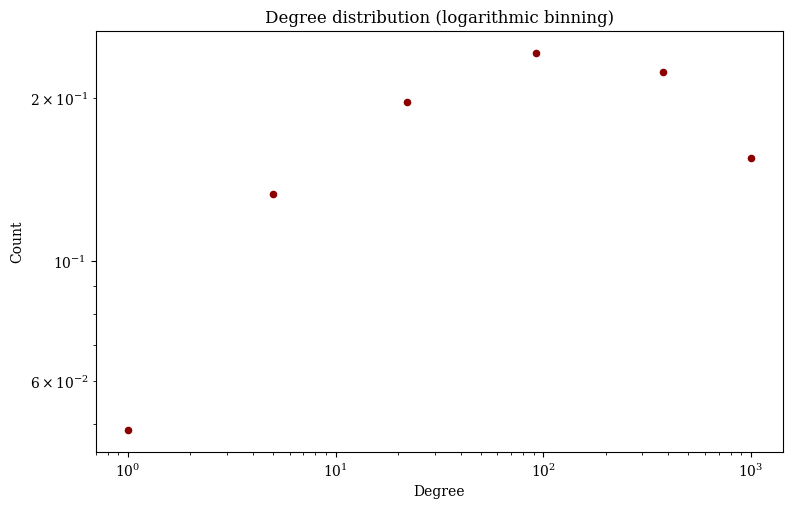

In [41]:
log_df = log_bin(gdn_deg,b=2)

fig,ax = newfig(1.5)
log_df.plot.scatter(x="k",y="p(k)",loglog=True,ax=ax,title="Degree distribution (logarithmic binning)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/viktortorpthomsen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


<Figure size 640x480 with 0 Axes>

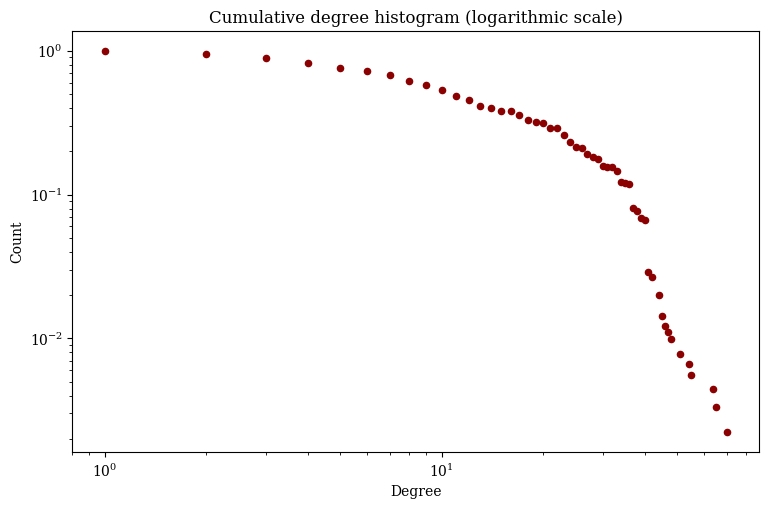

In [42]:
fig,ax = newfig(1.5)
gdn_deg.plot.scatter(x="k",y="cum_p(k)",loglog=True,ax=ax,title="Cumulative degree histogram (logarithmic scale)",c="darkred")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()